# NeuralTreeNet and ONNX

La conversion d'un arbre de décision au format ONNX peut créer des différences entre le modèle original et le modèle converti (voir [Issues when switching to float](http://www.xavierdupre.fr/app/onnxcustom/helpsphinx/gyexamples/plot_ebegin_float_double.html). Le problème vient d'un changement de type, les seuils de décisions sont arrondis au float32 le plus proche de leur valeur en float64 (double). Qu'advient-il si l'arbre de décision est converti en réseau de neurones d'abord.

L'approximation des seuils de décision ne change pas grand chose dans la majorité des cas. Cependant, il est possible que la comparaison d'une variable à un seuil de décision arrondi soit l'opposé de celle avec le seuil non arrondi. Dans ce cas, la décision suit un chemin différent dans l'arbre.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## Jeu de données

On construit un jeu de donnée aléatoire.

In [4]:
import numpy

X = numpy.random.randn(10000, 10)
y = X.sum(axis=1) / X.shape[1] + numpy.random.randn(X.shape[0]) / 2000
X = X.astype(numpy.float64)
y = y.astype(numpy.float64)

In [5]:
middle = X.shape[0] // 2
X_train, X_test = X[:middle], X[middle:]
y_train, y_test = y[:middle], y[middle:]

## Partie scikit-learn

### Caler un arbre de décision

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.8645606992691686, 0.4077225150357101)

In [7]:
from sklearn.metrics import r2_score
r2_score(y_test, tree.predict(X_test))

0.4077225150357101

### Conversion au format ONNX

In [8]:
from mlprodict.onnx_conv import to_onnx

onx = to_onnx(tree, X[:1].astype(numpy.float32))

In [9]:
from mlprodict.onnxrt import OnnxInference

x_exp = X_test

oinf = OnnxInference(onx, runtime='onnxruntime1')
expected = tree.predict(x_exp)

got = oinf.run({'X': x_exp.astype(numpy.float32)})['variable']
numpy.abs(got - expected).max()

1.9300789394897055

In [10]:
from mlprodict.plotting.text_plot import onnx_simple_text_plot
onnx_simple_text_plot(onx)

"opset: domain='ai.onnx.ml' version=1\nopset: domain='' version=15\ninput: name='X' type=dtype('float32') shape=[None, 10]\nTreeEnsembleRegressor(X, n_targets=1, nodes_falsenodeids=1735:[842,435,218...0,0,0], nodes_featureids=1735:[3,9,1...0,0,0], nodes_hitrates=1735:[1.0,1.0...1.0,1.0], nodes_missing_value_tracks_true=1735:[0,0,0...0,0,0], nodes_modes=1735:[b'BRANCH_LEQ',b'BRANCH_LEQ'...b'LEAF',b'LEAF'], nodes_nodeids=1735:[0,1,2...1732,1733,1734], nodes_treeids=1735:[0,0,0...0,0,0], nodes_truenodeids=1735:[1,2,3...0,0,0], nodes_values=1735:[-0.14788652956485748,0.1124945729970932...0.0,0.0], post_transform=b'NONE', target_ids=868:[0,0,0...0,0,0], target_nodeids=868:[10,11,13...1732,1733,1734], target_treeids=868:[0,0,0...0,0,0], target_weights=868:[-0.9847356677055359,-0.9220503568649292...1.0245341062545776,0.8101320862770081]) -> variable\noutput: name='variable' type=dtype('float32') shape=[None, 1]"

## Après la conversion en un réseau de neurones

### Conversion en un réseau de neurones

Un paramètre permet de faire varier la pente des fonctions sigmoïdes utilisées.

In [11]:
from tqdm import tqdm
from pandas import DataFrame
from mlstatpy.ml.neural_tree import NeuralTreeNet

xe = x_exp[:500]
expected = tree.predict(xe)

data = []
trees = {}
for i in tqdm([0.3, 0.4, 0.5, 0.7, 0.9, 1] + list(range(5, 61, 5))):
    root = NeuralTreeNet.create_from_tree(tree, k=i, arch='compact')
    got = root.predict(xe)[:, -1]
    me = numpy.abs(got - expected).mean()
    mx = numpy.abs(got - expected).max()
    obs = dict(k=i, max=mx, mean=me)
    data.append(obs)
    trees[i] = root

100%|██████████| 18/18 [00:05<00:00,  3.14it/s]


In [12]:
df = DataFrame(data)
df

,k,max,mean
0,0.3,1.341325,0.295485
1,0.4,0.669381,0.163060
2,0.5,0.790209,0.166492
3,0.7,0.871027,0.184475
4,0.9,0.894633,0.184283
5,1.0,0.899989,0.180919
6,5.0,0.601072,0.035020
7,10.0,0.413121,0.007813
8,15.0,0.259682,0.002347
9,20.0,0.169421,0.001562


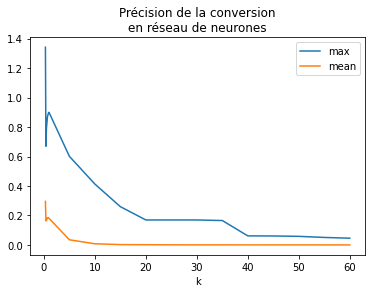

In [13]:
df.set_index('k').plot(title="Précision de la conversion\nen réseau de neurones");

L'erreur est meilleure mais il faudrait recommencer l'expérience plusieurs fois avant de pouvoir conclure afin d'obtenir un interval de confiance pour le même type de jeu de données. Ce sera pour une autre fois. Le résultat dépend du jeu de données et surtout de la proximité des seuils de décisions. Néanmoins, on calcule l'erreur sur l'ensemble de la base de test. Celle-ci a été tronquée pour aller plus vite.

In [14]:
expected = tree.predict(x_exp)
got = trees[50].predict(x_exp)[:, -1]
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(0.5220511194985693, 0.000318675264010377)

On voit que l'erreur peut-être très grande. Elle reste néanmoins plus petite que l'erreur de conversion introduite par ONNX.

### Conversion au format ONNX

On crée tout d'abord une classe qui suit l'API de scikit-learn et qui englobe l'arbre qui vient d'être créé qui sera ensuite convertit en ONNX.

In [15]:
from mlstatpy.ml.neural_tree import NeuralTreeNetRegressor

reg = NeuralTreeNetRegressor(trees[50])
onx2 = to_onnx(reg, X[:1].astype(numpy.float32))

In [16]:
print(onnx_simple_text_plot(onx2))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=[None, 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(8670,)
init: name='Ad_Addcst' type=dtype('float32') shape=(867,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(752556,)
init: name='Ad_Addcst1' type=dtype('float32') shape=(868,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(868,)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                    Id

In [17]:
oinf2 = OnnxInference(onx2, runtime='onnxruntime1')
expected = tree.predict(x_exp)

got = oinf2.run({'X': x_exp.astype(numpy.float32)})['variable']
numpy.abs(got - expected).max()

1.9300789394897055

L'erreur est la même.

## Temps de calcul

In [18]:
x_exp32 = x_exp.astype(numpy.float32)

Tout d'abord le temps de calcul pour scikit-learn.

In [19]:
%timeit tree.predict(x_exp32)

682 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Le temps de calcul pour l'arbre de décision au format ONNX.

In [20]:
%timeit oinf.run({'X': x_exp32})['variable']

275 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Et le temps de calcul pour le réseau de neurones au format ONNX.m

In [21]:
%timeit oinf2.run({'X': x_exp32})['variable']

83.5 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ce temps de calcul très long est attendu car le modèle contient une multiplication de matrice très grande.

In [22]:
for node in trees[50].nodes:
    print(node.coef.shape, node.bias.shape)

(867, 11) (867,)
(868, 868) (868,)
(869,) ()


Cela dit, la plus grande matrice est creuse, elle peut être réduite considérablement.

In [23]:
from scipy.sparse import csr_matrix

for node in trees[50].nodes:
    csr = csr_matrix(node.coef)
    print(f"coef.shape={node.coef.shape}, size dense={node.coef.size}, "
          f"size sparse={csr.size}, ratio={csr.size / node.coef.size}")

coef.shape=(867, 11), size dense=9537, size sparse=1734, ratio=0.18181818181818182
coef.shape=(868, 868), size dense=753424, size sparse=9415, ratio=0.012496283633120261
coef.shape=(869,), size dense=869, size sparse=868, ratio=0.998849252013809


In [24]:
r = numpy.random.randn(trees[50].nodes[1].coef.shape[0])
mat = trees[50].nodes[1].coef
%timeit mat @ r

213 µs ± 3.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
csr = csr_matrix(mat)
%timeit csr @ r

15.3 µs ± 313 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Ce serait beaucoup plus rapide avec une matrice sparse. Le modèle ONNX se décompose comme suit.

In [26]:
print(onnx_simple_text_plot(onx2))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=[None, 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(8670,)
init: name='Ad_Addcst' type=dtype('float32') shape=(867,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(752556,)
init: name='Ad_Addcst1' type=dtype('float32') shape=(868,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(868,)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                    Id

Voyons comment le temps de calcul se répartit.

In [27]:
oinfpr = OnnxInference(onx2, runtime="onnxruntime1",
                      runtime_options={"enable_profiling": True})
for i in range(0, 43):
    oinfpr.run({"X": x_exp32})

In [28]:
df = oinfpr.get_profiling(as_df=True)
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_parameter_size,args_graph_index,args_provider,args_exec_plan_index,args_activation_size,args_output_size,args_input_type_shape,args_output_type_shape,args_thread_scheduling_stats
0,Session,71460,89468,1245,3,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,71460,89468,4833,1642,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,71460,89468,0,6735,X,gemm_fence_before,Gemm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,71460,89468,5411,6739,X,gemm_kernel_time,Gemm,38148,11,CPUExecutionProvider,11,200000,17340000,"[{'float': [5000, 10]}, {'float': [10, 867]}, ...","[{'float': [5000, 867]}]",{'main_thread': {'thread_pool_name': 'session-...
4,Node,71460,89468,0,12167,X,gemm_fence_after,Gemm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,Node,71460,89468,0,3746899,X,Ma_MatMul2_fence_before,MatMul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,Node,71460,89468,887,3746900,X,Ma_MatMul2_kernel_time,MatMul,3472,8,CPUExecutionProvider,8,17360000,20000,"[{'float': [5000, 868]}, {'float': [868, 1]}]","[{'float': [5000, 1]}]",{'main_thread': {'thread_pool_name': 'session-...
988,Node,71460,89468,0,3747795,X,Ma_MatMul2_fence_after,MatMul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989,Session,71460,89468,88831,3658968,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
set(df['args_provider'])

{'CPUExecutionProvider', nan}

In [30]:
dfp = df[df.args_provider == 'CPUExecutionProvider'].copy()
dfp['name'] = dfp['name'].apply(lambda s: s.replace("_kernel_time", ""))
gr_dur = dfp[['dur', "args_op_name", "name"]].groupby(["args_op_name", "name"]).sum().sort_values('dur')
gr_dur

dur
args_op_name name                 
MatMul       Ma_MatMul2      39710
Mul          Mu_Mul1         97282
Sigmoid      Si_Sigmoid      98096
             Si_Sigmoid1     98591
Mul          Mu_Mul         100221
Gemm         gemm           184563
             gemm_token_0  3111581

In [31]:
gr_n = dfp[['dur', "args_op_name", "name"]].groupby(["args_op_name", "name"]).count().sort_values('dur')
gr_n = gr_n.loc[gr_dur.index, :]
gr_n

dur
args_op_name name             
MatMul       Ma_MatMul2     43
Mul          Mu_Mul1        43
Sigmoid      Si_Sigmoid     43
             Si_Sigmoid1    43
Mul          Mu_Mul         43
Gemm         gemm           43
             gemm_token_0   43

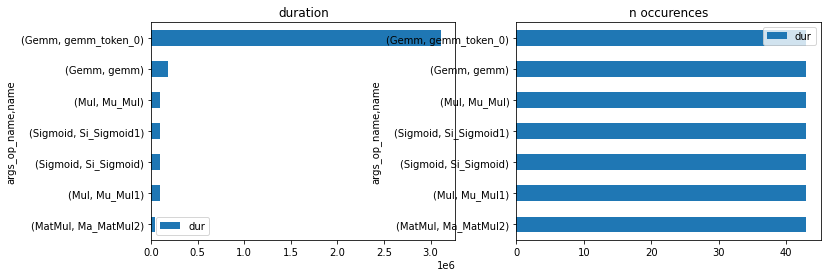

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration")
ax[1].set_title("n occurences");

onnxruntime passe principalement son temps dans un produit matriciel. On vérifie plus précisément.

In [33]:
df[(df.args_op_name == 'Gemm') & (df.dur > 0)].sort_values('dur', ascending=False).head(n=2).T

,426,12
cat,Node,Node
pid,71460,71460
tid,89468,89468
dur,101064,97222
ts,1511573,17402
ph,X,X
name,gemm_token_0_kernel_time,gemm_token_0_kernel_time
args_op_name,Gemm,Gemm
args_parameter_size,3013696,3013696
args_graph_index,12,12


C'est un produit matriciel d'environ *5000x800* par *800x800*.

In [34]:
gr_dur / gr_dur.dur.sum()

dur
args_op_name name                  
MatMul       Ma_MatMul2    0.010646
Mul          Mu_Mul1       0.026081
Sigmoid      Si_Sigmoid    0.026299
             Si_Sigmoid1   0.026432
Mul          Mu_Mul        0.026869
Gemm         gemm          0.049480
             gemm_token_0  0.834194

In [35]:
r = (gr_dur / gr_dur.dur.sum()).dur.max()
r

0.8341941810874081

Il occupe 82% du temps. et d'après l'expérience précédente, son temps d'éxecution peut-être réduit par 10 en le remplaçant par une matrice sparse. Cela ne suffira pas pour accélerer le temps de calcul de ce réseau de neurones. Il est 84 ms comparé à 247 µs pour l'arbre de décision. Avec cette optimisation, il pourrait passer de :

In [36]:
t = 84
t * (1 - r) + r * t / 12

19.76704805626958

Soit une réduction du temps de calcul par 4. Ce n'est pas mal mais pas assez.

## Hummingbird

[hummingbird](https://github.com/microsoft/hummingbird) est une librairie qui convertit un arbre de décision en réseau de neurones. Voyons ses performances.

In [37]:
from hummingbird.ml import convert

model = convert(tree, 'torch')

expected = tree.predict(x_exp)
got = model.predict(x_exp)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


(2.9793571165726007e-08, 4.972897520481769e-09)

Le résultat est beaucoup plus fidèle au modèle.

In [38]:
%timeit model.predict(x_exp)

1.75 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Il reste plus lent mais beaucoup plus rapide que la solution manuelle proposée dans les précédents paragraphes. Il contient un attribut `model`.

In [39]:
from torch.nn import Module
isinstance(model.model, Module)

True

On convertit ce modèle au format ONNX.

In [40]:
import torch.onnx

x = torch.randn(x_exp.shape[0], x_exp.shape[1], requires_grad=True)
torch.onnx.export(model.model, x, 'tree_torch.onnx', opset_version=15,                         
                  input_names=['X'], output_names=['variable'],
                  dynamic_axes={
                      'X' : {0 : 'batch_size'},
                      'variable' : {0 : 'batch_size'}})

In [41]:
import onnx

onxh = onnx.load('tree_torch.onnx')

In [42]:
try:
    print(onnx_simple_text_plot(onxh))
except Exception as e:
    print("BUG", e)

BUG Unexpected empty sequence (len(possibles)=0, len(done)=0, len(nodes)=119). This is usually due to a name used both as result name and node node. known={'_operators.0.nodes.2', '_operators.0.root_nodes', '_operators.0.nodes.6', '_operators.0.nodes.4', '_operators.0.nodes.3', '_operators.0.biases.4', '_operators.0.biases.6', '_operators.0.tree_indices', '_operators.0.nodes.0', '_operators.0.nodes.8', 'X', '_operators.0.biases.7', '_operators.0.biases.8', '_operators.0.biases.0', '_operators.0.nodes.5', '_operators.0.biases.1', '_operators.0.root_biases', '_operators.0.biases.5', '_operators.0.leaf_nodes', '_operators.0.nodes.1', '_operators.0.biases.2', '_operators.0.biases.3', '_operators.0.nodes.7'}.


In [43]:
oinfh = OnnxInference(onxh, runtime='onnxruntime1')
expected = tree.predict(x_exp)

got = oinfh.run({'X': x_exp.astype(numpy.float32)})['variable']
numpy.abs(got - expected).max()

1.9300789394897055

La conversion reste imparfaite également.

In [44]:
%timeit oinfh.run({'X': x_exp32})['variable']

4 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Et le temps de calcul est aussi plus long.

## Apprentissage